A notebook version of the script Amanda wrote.

Seems to only work when loaded version of the kernel is the `~/src/mambaforge` one.

In [1]:
# Imports
from obspy.core import read, Stream
import numpy as np
import matplotlib.pyplot as plt
import lfe_unet_tools
from scipy.signal import find_peaks
import pickle
import datetime

2024-01-19 12:13:35.168224: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 12:13:35.168260: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 12:13:35.168286: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 12:13:35.176074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# A function to normalize data and convert to CNN input format
def ZEN2inp(Z,E,N,epsilon):
    '''
    Apply feature normalizations to raw timeseries and convert
    to CNN input format

    Parameters:
        Z (float array): The vertical component data.
        E (float array): The east component data.
        N (float array): The north component data.
        epsilon (float): constant value added to input data to avoid zeros.

    Returns:
        data_inp (float array): CNN input
    '''
    data_Z_sign = np.sign(Z)
    data_E_sign = np.sign(E)
    data_N_sign = np.sign(N)
    data_Z_val = np.log(np.abs(Z)+epsilon)
    data_E_val = np.log(np.abs(E)+epsilon)
    data_N_val = np.log(np.abs(N)+epsilon)
    data_inp = np.hstack([data_Z_val.reshape(-1,1),data_Z_sign.reshape(-1,1),
                          data_E_val.reshape(-1,1),data_E_sign.reshape(-1,1),
                          data_N_val.reshape(-1,1),data_N_sign.reshape(-1,1),])
    return data_inp

In [3]:
# Set up model
# --> Parameters you can modify
thresh = 0.1  # minimum decision threshold to log detections
shift = 15  # time window step size in seconds
drop = 0 # drop layer, 1 if you want to include, 0 if not
large = 0.5  # model size (can be 0.5, 1, 2)
std = 0.2  # how wide do you want the gaussian STD to be in seconds?
plots = 1 # do you want plots?

# --> Parameters you should not modify
sr = 100. # sample rate in Hz, network was trained on 100Hz data so best keep this as is
winlen = 15.  # window length in seconds
nwin = int(sr*winlen)  # number of windows
nshift = int(sr*shift)  # number of samples to shift window
epsilon = 1e-6  # normalization parameter

# --> Build model
model_save_file="large_"+'{:3.1f}'.format(large)+"_unet_lfe_std_"+str(std)+".tf"

if drop:
    model_save_file="drop_"+model_save_file

print("Building the model...")
if drop:
    model=lfe_unet_tools.make_large_unet_drop(large,sr,ncomps=3)
else:
    model=lfe_unet_tools.make_large_unet(large,sr,ncomps=3)

# --> Load model parameters
print('Loading training results from '+model_save_file)
model.load_weights("./models_v2/"+model_save_file)

Building the model...


2024-01-19 12:13:38.120457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9580 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1500, 6)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1500, 16)             2032      ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 750, 16)              0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 750, 32)              7712      ['max_pooling1d[0][0]']   

In [4]:
# Load data
day = 5
stations = ['40','B079','THIS']  # available stations in Amandas example
ii_sta = 2
sta = stations[ii_sta]

print(sta+' '+str(day))
st = Stream()
if sta=='40':
    st=read("data/1B.40..DPZ.2018-08-0"+str(day)+"-00-00-00.ms")
    st+=read("data/1B.40..DP1.2018-08-0"+str(day)+"-00-00-00.ms")
    st+=read("data/1B.40..DP2.2018-08-0"+str(day)+"-00-00-00.ms")
elif sta=="THIS":
    st+=read("data/2018-08-0"+str(day)+".BK."+sta+".HHZ.ms")
    st+=read("data/2018-08-0"+str(day)+".BK."+sta+".HHE.ms")
    st+=read("data/2018-08-0"+str(day)+".BK."+sta+".HHN.ms")
elif sta=="B079":
    st+=read("data/2018-08-0"+str(day)+".PB."+sta+".EHZ.ms")
    st+=read("data/2018-08-0"+str(day)+".PB."+sta+".EH1.ms")
    st+=read("data/2018-08-0"+str(day)+".PB."+sta+".EH2.ms")

THIS 5


In [5]:
# Preprocess data
# --> Filter
st.detrend(type='simple')
st.filter("highpass", freq=1.0, zerophase=True)

# --> Enforce components to have the same start/end times
start = st[0].stats.starttime
finish = st[0].stats.endtime

print(start, finish)
for ii in range(1, len(st)):
    if start < st[ii].stats.starttime:
        start = st[ii].stats.starttime
    if finish > st[ii].stats.endtime:
        finish = st[ii].stats.endtime
st.trim(starttime=start, endtime=finish, nearest_sample=1, pad=1, fill_value=0)

# --> Interpolate if sr is not 100 Hz
for tr in st:
    if sr != tr.stats.sampling_rate:
        tr.interpolate(sampling_rate=sr, starttime=start)

2018-08-05T00:00:00.000000Z 2018-08-05T23:59:59.990000Z


In [6]:
# Apply model to data
nn = (len(st[0].data) - nwin) // nshift  # number of windows to process
sdects = []  # intialize detection structure
sav_data = []

codestart=datetime.datetime.now()  # start timer

for ii in range(nn+1):
    data0s = lfe_unet_tools.simple_detrend(st[0].data[ii*nshift:ii*nshift+nwin])
    data1s = lfe_unet_tools.simple_detrend(st[1].data[ii*nshift:ii*nshift+nwin])
    data2s = lfe_unet_tools.simple_detrend(st[2].data[ii*nshift:ii*nshift+nwin])

    snip = np.concatenate((data0s,data1s,data2s))
    data_inp = ZEN2inp(data0s,data1s,data2s,epsilon)
    sav_data.append(data_inp)  # run model prediction in batch
sav_data = np.array(sav_data)

# make s predictions
stmp = model.predict(sav_data)
stmp = stmp.ravel()
spk = find_peaks(stmp, height=thresh, distance=200)
sdects = np.hstack((spk[0].reshape(-1,1)/sr, spk[1]['peak_heights'].reshape(-1,1)))

codestop = datetime.datetime.now() # stop timer

2024-01-19 12:13:48.155968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800


180/180 [==============================] - 18s 4ms/step


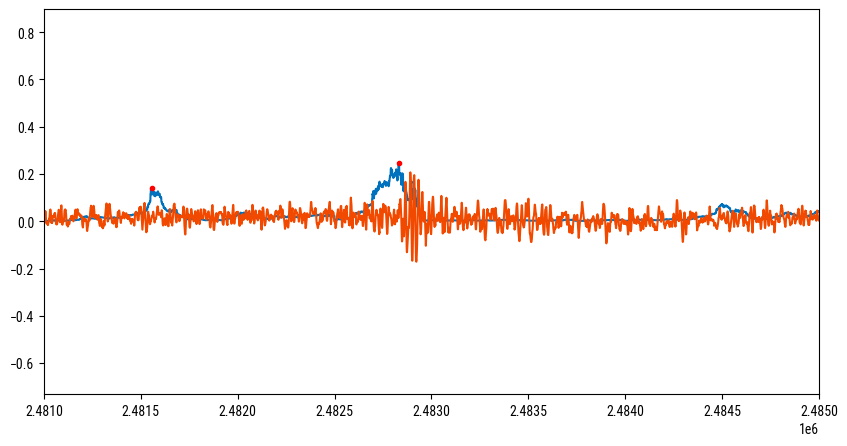

In [25]:
plt.figure(figsize=(10,5))
plt.plot(stmp)
plt.plot(st[2].data/1000)
plt.plot(spk[0],spk[1]['peak_heights'],'r.')
plt.xlim(24810*100, 24850*100)
plt.show()